## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1: 
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 5')

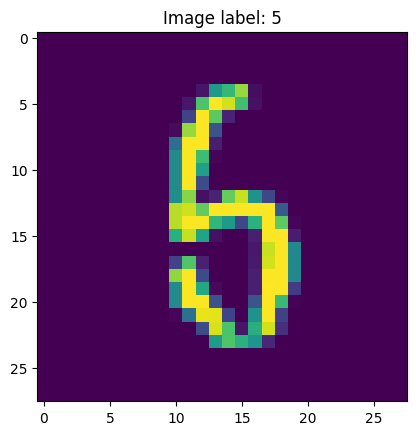

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_mnist_data = MNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [ ]:
# Creating model instance
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.model(x)
    
model = SimpleNN()  

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cpu")
model.to(device)

learning_rate = 0.01

def loss_fn(predictions, targets):
    return F.cross_entropy(predictions, targets)


def train_model(model, train_loader):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
        model.zero_grad()
        
@torch.no_grad()
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

n_epochs = 10
for epoch in range(n_epochs):
    train_model(model, train_data_loader)
    accuracy = test_model(model, test_data_loader)
    print(f"Epoch {epoch+1}: Test Accuracy = {accuracy:.2f}%")


Epoch 1: Test Accuracy = 82.99%
Epoch 2: Test Accuracy = 89.46%
Epoch 3: Test Accuracy = 91.84%
Epoch 4: Test Accuracy = 93.32%
Epoch 5: Test Accuracy = 94.18%
Epoch 6: Test Accuracy = 95.01%
Epoch 7: Test Accuracy = 95.49%
Epoch 8: Test Accuracy = 95.79%
Epoch 9: Test Accuracy = 96.06%
Epoch 10: Test Accuracy = 96.49%


Локальные тесты для проверки вашей модели доступны ниже:

In [6]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, "Please, use `model` variable to store your model"

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

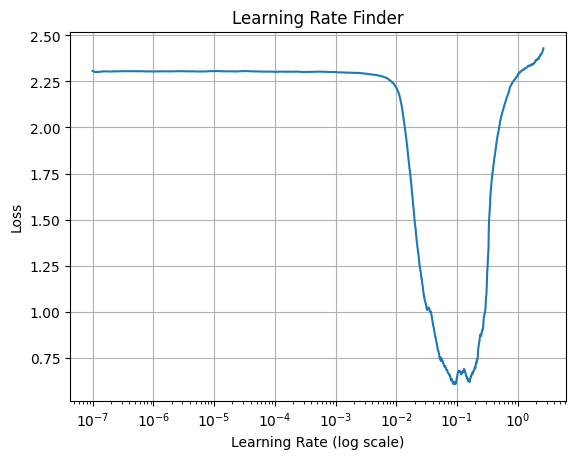

In [11]:
import matplotlib.pyplot as plt

# Learning Rate Finder
def find_lr(model, train_loader, init_lr=1e-7, final_lr=10, beta=0.98):
    num = len(train_loader) - 1
    mult = (final_lr / init_lr) ** (1/num)
    lr = init_lr
    optimizer = {}
    
    # Инициализация
    velocity = {}
    losses = []
    lrs = []
    
    avg_loss = 0.0
    best_loss = float('inf')
    batch_num = 0
    
    for images, labels in train_loader:
        batch_num += 1
        
        images, labels = images, labels  # всё на CPU
        
        # Подаем данные в модель
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        
        # Сглаживание потерь (скользящее среднее)
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        # Запоминаем learning_rate и loss
        lrs.append(lr)
        losses.append(smoothed_loss)
        
        # Если loss вырос в 4 раза — останавливаем
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break
        
        # Запоминаем лучший loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        # Градиенты и обновление параметров вручную
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                if param not in velocity:
                    velocity[param] = torch.zeros_like(param.grad)
                velocity[param] = 0.9 * velocity[param] + param.grad
                param -= lr * velocity[param]
        model.zero_grad()
        
        # Увеличиваем learning_rate
        lr *= mult
    
    return lrs, losses

# 🚀 Запускаем:
model = SimpleNN()  # новая чистая модель
lrs, losses = find_lr(model, train_data_loader)

# 📈 Строим график
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')
plt.grid(True)
plt.show()


In [12]:
# Creating model instance
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.model(x)
    
model = SimpleNN()  

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cpu")
model.to(device)

learning_rate = 0.01 # самый оптимальный lr из графика выше

def loss_fn(predictions, targets):
    return F.cross_entropy(predictions, targets)


def train_model(model, train_loader):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
        model.zero_grad()
        
@torch.no_grad()
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

n_epochs = 10
for epoch in range(n_epochs):
    train_model(model, train_data_loader)
    accuracy = test_model(model, test_data_loader)
    print(f"Epoch {epoch+1}: Test Accuracy = {accuracy:.2f}%")


Epoch 1: Test Accuracy = 86.41%
Epoch 2: Test Accuracy = 89.72%
Epoch 3: Test Accuracy = 91.76%
Epoch 4: Test Accuracy = 94.10%
Epoch 5: Test Accuracy = 94.72%
Epoch 6: Test Accuracy = 95.43%
Epoch 7: Test Accuracy = 95.90%
Epoch 8: Test Accuracy = 96.19%
Epoch 9: Test Accuracy = 96.44%
Epoch 10: Test Accuracy = 96.79%


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [13]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [14]:
print(f"Neural network accuracy on train set: {train_acc:3.5}")

Neural network accuracy on train set: 0.97355


In [15]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [16]:
print(f"Neural network accuracy on test set: {test_acc:3.5}")

Neural network accuracy on test set: 0.9679


Проверка, что необходимые пороги пройдены:

In [17]:
assert test_acc >= 0.92, "Test accuracy is below 0.92 threshold"
assert (
    train_acc >= 0.91
), "Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow"

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки.

In [18]:
# do not change the code in the block below
# __________start of block__________
import os
import json

assert os.path.exists(
    "hw07_data_dict.npy"
), "Please, download `hw07_data_dict.npy` and place it in the working directory"


def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels_np = torch.cat(predicted_labels).numpy()
    predicted_labels_str = ",".join([str(x) for x in list(predicted_labels)])
    return predicted_labels_np, predicted_labels_str


loaded_data_dict = np.load("hw07_data_dict.npy", allow_pickle=True)

train_labels_np, train_labels_str = get_predictions(
    model, torch.FloatTensor(loaded_data_dict.item()["train"])
)
test_labels_np, test_labels_str = get_predictions(
    model, torch.FloatTensor(loaded_data_dict.item()["test"])
)

submission_dict_str = {
    "train": train_labels_str,
    "test": test_labels_str,
}

submission_dict_np = {
    "train": train_labels_np,
    "test": test_labels_np,
}

np.save("submission_dict_hw07.npy", submission_dict_np, allow_pickle=True)
with open("submission_dict_hw07.json", "w") as iofile:
    json.dump(submission_dict_str, iofile)
print("File saved to `submission_dict_hw07.json` and `submission_dict_hw07.npy`")
# __________end of block__________

File saved to `submission_dict_hw07.json` and `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!